Cross-validate a model across the entire training data set. Its predictions will be stacked as features for regulatory element specific models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, \
    precision_recall_curve, auc
from sklearn.preprocessing.label import LabelBinarizer
from models import Classifier, Regression
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot, DNase
from cagi5_utils import get_breakpoint_df
from crossval import ChunkCV, CVOperator, df_cv_split
from utils import make_plots
import matplotlib.cm as cm

## Load data

Read the training data with added conservation information.

In [2]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


In [3]:
submission = pd.read_csv(
    'data/submission-with-cons.tsv',
    sep='\t',
    na_values='*')
submission.sample(6)

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,Direction,P_Direction,Confidence,SE,Comments,phastCon,phyloP,GerpN,GerpRS
4219,5,1295124,A,C,TERT-HEK293T,NaN,NaN,NaN,NaN,NaN,0.005,-1.105,3.62,-7.23
9574,10,51549267,G,C,MSMB,NaN,NaN,NaN,NaN,NaN,0.051,0.559,3.48,1.61
2839,1,209989136,T,G,IRF6,NaN,NaN,NaN,NaN,NaN,0.019,0.530,3.75,3.75
1221,1,109817827,T,C,SORT1,NaN,NaN,NaN,NaN,NaN,0.854,0.455,4.51,4.51
5642,6,396290,T,A,IRF4,NaN,NaN,NaN,NaN,NaN,0.543,0.455,5.27,5.27
13496,X,138612846,C,G,F9,NaN,NaN,NaN,NaN,NaN,0.986,0.581,5.32,5.32


## Breakpoints

Calculate the breakpoints inside each regulatory element.

In [4]:
breakpoint_df = get_breakpoint_df(df)
# Save breakpoints to CSV
breakpoint_df.to_csv('data/cagi5_bkpt.csv')
# Look at breakpoints
breakpoint_df[breakpoint_df['is_break']!='no'].head(15)

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.470,3.93,1.4900,start,NaN,True,0.0
47,X,138612684,G,T,-0.02,0.00,0,release_F9,0.048,-0.233,3.45,-2.0100,end,16.0,False,0.0
48,X,138612701,T,A,-0.36,0.37,-1,release_F9,0.009,0.470,3.27,1.9200,start,NaN,True,1.0
95,X,138612716,G,T,-0.15,0.04,0,release_F9,0.055,0.581,3.32,0.4310,end,16.0,False,1.0
96,X,138612765,C,A,0.07,0.01,0,release_F9,0.420,-0.304,4.22,0.2990,start,NaN,True,2.0
143,X,138612780,T,G,0.18,0.02,0,release_F9,0.525,0.470,4.69,4.6900,end,16.0,False,2.0
144,X,138612877,G,A,-0.09,0.05,0,release_F9,0.864,0.581,5.08,5.0800,start,NaN,True,3.0
190,X,138612892,C,T,0.12,0.01,0,release_F9,0.508,0.581,5.08,1.7900,end,16.0,False,3.0
191,X,138612909,C,A,0.05,0.02,0,release_F9,0.453,0.581,5.08,0.0736,start,NaN,True,4.0
235,X,138612924,A,G,-0.01,0.00,0,release_F9,0.614,0.470,4.55,0.6710,end,16.0,False,4.0


## Cross-validation folds

Split the training data into folds respecting the breakpoints.

In [5]:
nfolds = 5
fold_dict = df_cv_split(breakpoint_df, nfolds)
fold_dict

{'release_F9': [[3], [4], [1], [0], [2]],
 'release_GP1BB': [[2, 5], [0], [3], [4], [1]],
 'release_HBB': [[1], [0], [2], [], []],
 'release_HBG1': [[0], [1], [2], [3], []],
 'release_HNF4A': [[3], [1], [0], [2], []],
 'release_IRF4': [[3, 1], [6, 4], [5, 2], [0], [7]],
 'release_IRF6': [[1, 5], [4, 7], [3, 2], [8, 0], [6]],
 'release_LDLR': [[2], [1], [3], [4], [0]],
 'release_MSMB': [[8, 6], [1, 0], [5, 4], [3, 2], [7]],
 'release_MYCrs6983267': [[5, 0], [4, 7], [2, 6], [1, 8], [3]],
 'release_PKLR': [[6, 5], [0, 1], [3, 4], [2], [7]],
 'release_SORT1': [[4, 5], [7, 6], [8, 1], [3, 0], [2]],
 'release_TERT-GBM': [[1], [0], [2], [3], [4]],
 'release_TERT-HEK293T': [[0], [2], [3], [4], [1]],
 'release_ZFAND3': [[2, 0, 4], [5, 10], [3, 7], [8, 6], [1, 9]]}

## Create features

In [13]:
deepseadiffs = DeepSeaSNP(filename_fmt='deepsea_{}_preds.npy')
deepseadiffs_test = DeepSeaSNP(filename_fmt='deepsea-test_{}_preds.npy')
dnase = DNase()
dnase_test = DNase(test=True)
conservation = Conservation()
enhancer1hot = EnhancerOneHot()

## Model

Choose the model we are going to use

In [7]:
model = Regression
model_kwargs = {'model_name': 'xgb'}

## Enhancer one-hot

Create stacked data without enhancer one-hot feature

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4
0.7176929047691759 0.50063269233605


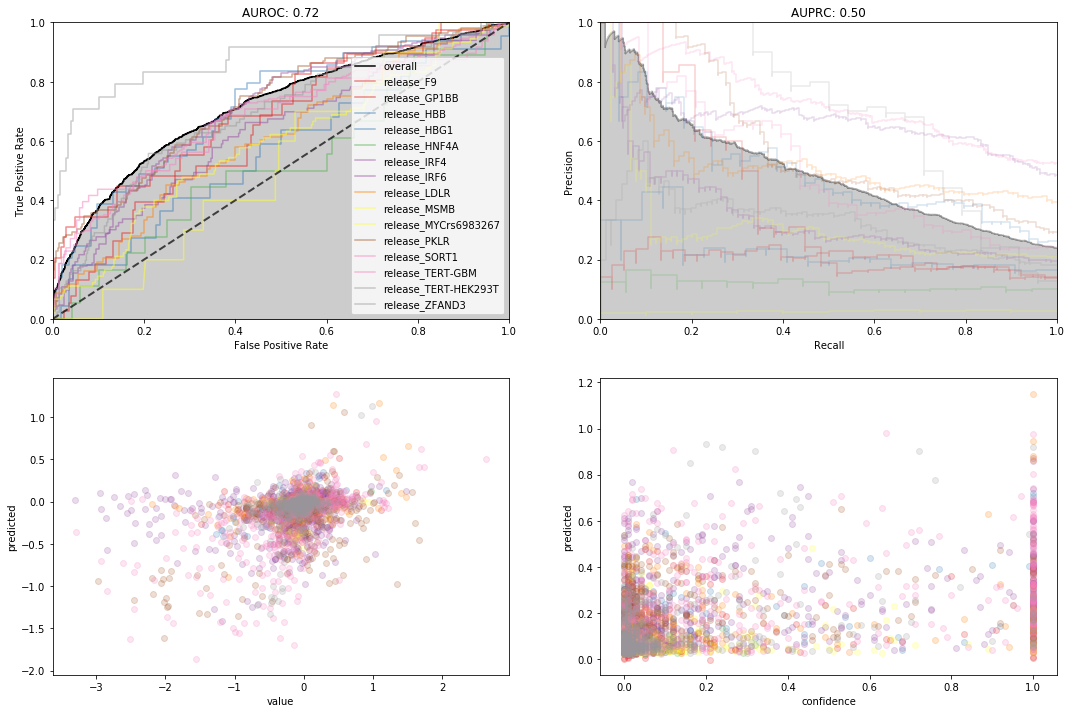

In [8]:
model_kwargs['features'] = MultiFeatures([deepseadiffs, dnase, conservation])
cv_chunk = ChunkCV(df, operator=CVOperator(model, model_kwargs=model_kwargs), fold_dict=fold_dict)
cv_woe1h = cv_chunk.get_cv_preds()
(fpr, tpr, thresholds, auroc), (precision, recall, thresholds, auprc), _, _ = make_plots(cv_woe1h)
print(auroc, auprc)

In [9]:
tag = 'deep-dnase-cons'
cv_woe1h.to_csv('data/stacked-{}.csv'.format(tag))
np.save(
    'data/stacked-{}.npy'.format(tag),
    cv_woe1h.loc[:, ('PredValue', 'PredConfidence')].as_matrix())

Fit the model on the whole training data to make predictions on the submission data

In [11]:
test_model = model(**model_kwargs)
X_train = test_model.get_features(df)
y_train = test_model.get_response(df)
test_model.fit(X_train, y_train)

Make predictions on the submission data

In [15]:
test_features = MultiFeatures([deepseadiffs_test, dnase_test, conservation])
X_test = test_features.get_features(submission)
predictions = test_model.predict(X_test, submission.index)
predictions.sample(6)

,PredConfidence,PredValue
4825,0.151231,0.117390
4193,0.086714,0.027811
1046,0.212366,0.026675
5978,0.295714,-0.012285
9307,0.046672,0.032275
5654,0.341073,-0.052188


Save the predictions

In [17]:
tag = 'test-deep-dnase-cons'
predictions.to_csv('data/stacked-{}.csv'.format(tag))
np.save(
    'data/stacked-{}.npy'.format(tag),
    predictions.loc[:, ('PredValue', 'PredConfidence')].as_matrix())

## Enhancer one-hot

Create stacked data using enhancer one-hot feature

In [ ]:
model_kwargs['features'] = MultiFeatures([deepseadiffs, dnase, conservation, enhancer1hot])
cv_chunk = ChunkCV(df, operator=CVOperator(model, model_kwargs=model_kwargs), fold_dict=fold_dict)
cv_regress = cv_chunk.get_cv_preds()
(fpr, tpr, thresholds, auroc), (precision, recall, thresholds, auprc), _, _ = make_plots(cv_regress)
print(auroc, auprc)

In [ ]:
tag = 'deep-e1h-dnase-cons'
cv_regress.to_csv('data/stacked-{}.csv'.format(tag))
np.save(
    'data/stacked-{}.npy'.format(tag),
    cv_regress.loc[:, ('PredValue', 'PredConfidence')].as_matrix())